<a href="https://colab.research.google.com/github/simon-m-mudd/smm_teaching_notebooks/blob/master/Basic_topography/Lesson_02_coordinate_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 02: coordinate reference systems

*This lesson made by Simon M Mudd and last updated 22/11/2024*

In lesson 01 we learned how to download data, look at the information about the data (e.g., its dimensions, its *CRS*, the size of the pixels) and make simple plots.

You will need to have data files from the previous lesson, so if you have not done that lesson please open it and execute the cells (the quick way to do that is to use the `Restart & run all` button in the `Kernel` menu above).

In this lesson we will look at coordinate reference systems.

## Stuff we need to do if you are in colab (not required in the lsdtopotools pytools container)

**If you are in the `docker_lsdtt_pytools` docker container, you do not need to do any of this.
The following is for executing this code in the google colab environment only.**

If you are in the docker container you can skip to the **First get data** section.

In [ ]:
!wget https://pkgs.geos.ed.ac.uk/geos-jammy/pool/world/l/lsdtopotools2/lsdtopotools2_0.9-1geos~22.04.1_amd64.deb  &> /dev/null
!apt install ./lsdtopotools2_0.9-1geos~22.04.1_amd64.deb  &> /dev/null

The next line tests to see if it worked. If you get some output asking for a parameter file then `lsdtopotools` is installed. This notebook was tested on version 0.9.

In [ ]:
!lsdtt-basic-metrics -v

Now we install `lsdviztools`:

In [ ]:
!pip install lsdviztools  &> /dev/null

## First import some stuff we need

In [ ]:
import rasterio as rio
import matplotlib.pyplot as plt

## Lets look at the data from the last lesson

In the last lesson we grabbed a raster from [opentopography](https://opentopography.org/).
If you haven't done that lesson, go back and get the raster. It is called `rio_aguas_COP30.tif`

**If you are in google colab**: you need to download the raster and then upload it here. Or you can re-download it. In Notable you keep the files, but in google colab the system removes the files as soon as you close the window.

We can see if it is in this directory by calling the `!ls` command

In [ ]:
!ls

condacolab_install.log	sample_data


Now lets go back to the pixel sizes of the raster. I'll get them with rasterio:

In [ ]:
filename = "rio_aguas_COP30.tif"
with rio.open(filename) as src:
    print("\nRaster pixel sizes in the X,Y directions are:")
    print(src.res)


Raster pixel sizes in the X,Y directions are:
(0.0002777777777777778, 0.0002777777777777778)


What are these?

Copernicus and Alos world 3D datasets have "30" in their names, which is for 30 metre grid spacing. But the grid spacing isn't actually 30 m.

For more honest advertising, SRTM data is available in GL1 and GL3 versions from [OpenTopography](https://opentopography.org/). The "GL" stands for global and the 1 and 3 stand for 1 and 3 arcseconds, respectively. The arcsecond is the size of the pixels.

[Read about arcseconds here](https://en.wikipedia.org/wiki/Minute_and_second_of_arc)

If you don't want to read that, the summary is that an arcsecond is 1/3600 of a degree, which is 0.000277 in decimal degree format. This is the same size of the rasters in **ALW3D and COP30** data formats.

So the pixel size in this DEM is in decimal degrees.

1 arcsecond in decimal degrees is around 30 m at the equator. It changes as you change latitude. At high latitudes the X and Y dimensions will always be 1 arcsecond but the length in metres will change.

This is a bit of a problem for us because we like to do things like measure gradients and areas and distances in units like metres and metres squared: measuring, say, a river gradient in metres per arcsecond would seem rather silly.

This brings us to projections, transformations, and coordinate reference systems.

## Projections, transformations, and coordinate reference systems

I am not going to get into too much detail here, but the Earth is a sphere so one way to figure out where you are on the sphere is to use [geographic coordinates](https://en.wikipedia.org/wiki/Geographic_coordinate_system): latitude and longitude.

But you can also project this spherical surface onto a flat surface (e.g., a paper map). This is called a projection. A projection can allow you to convert your coordinates into distances or areas.

[You can spend all day reading about projections](https://en.wikipedia.org/wiki/Map_projection)

So, your **coordinate reference system** (or **crs**) can be either *geographic* or *projected*.

* Geographic coordinate systems have latitude and longitude coordinates, and the spatial units are decimal degrees
* Projected coordinate systems have spatial units in metres, although in the United States their system of measurement is still in the stone age and they use hilariously stupid imperial units (so "state planes" are in feet). The British National Grid is in metres.

### Common coordinate reference systems and the EPSG code

So what different coordinate reference systems are there? Well, there are lots of them. With funny names. But we have a system of identifying these systems. It is called an **EPSG** code.

The [EPSG code](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) is a shorthand for the coordinate reference system. Here are some common ones

**Geographic coordinate systems**
* EPSG:4326 - WGS 84, latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System among others.
* EPSG:3857 - Web Mercator projection used for display by many web-based mapping tools, including Google Maps and OpenStreetMap.

**Projected coordiante systems**
* EPSG:27700 British National Grid
* EPSG:326XX Universal Transverse Mercator, Northern hemisphere. The XX is the UTM zone
* EPSG:327XX Universal Transverse Mercator, Southern hemisphere. The XX is the UTM zone
* EPSG:3034 A projection that covers all of Europe (but a bit less accurate than UTM if you are in the correct zone).

UTM is a widely used projected coordinate system that can be used anywhere, provided you know the *UTM zone*. [Click here for a map of UTM zones](http://www.dmap.co.uk/utmworld.htm).

## Changing a raster's projection

The easiest way to do this is with our good friend gdal. You can also change the projection with the python package `rasterio`.

I'll do it both ways and show some gotchas.

First, we can use the gdal tool `gdalwarp`. As we learned in the last lesson, the gdal command line tools live in the linux environment that underpins a python notebook. So you need gdal installed and you also need to use the `!` symbol to call a script in linux. Here is how to do it:

In [ ]:
!gdalwarp -t_srs EPSG:3034 rio_aguas_COP30.tif rio_aguas_COP30_LCC.tif

Creating output file that is 1768P x 1285L.
Processing rio_aguas_COP30.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Now lets see what we got (with rasterio):

In [ ]:
filename = "rio_aguas_COP30_LCC.tif"
with rio.open(filename) as src:
    print("The metadata for this raster is:")
    print(src.meta)
    print("\nRaster pixel sizes in the X,Y directions are:")
    print(src.res)

The metadata for this raster is:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1768, 'height': 1285, 'count': 1, 'crs': CRS.from_epsg(3034), 'transform': Affine(25.857882435678906, 0.0, 2917185.4482518714,
       0.0, -25.857882435678906, 1292625.567080348)}

Raster pixel sizes in the X,Y directions are:
(25.857882435678906, 25.857882435678906)


Lets get two hillshades and compare them. We will use gdaldem for this. If you did the last lesson, you already have the SRTM hillshade. So we only need the new hillshade

In [ ]:
!gdaldem hillshade rio_aguas_COP30_LCC.tif rio_aguas_COP30_LCC_HS.tif -alg ZevenbergenThorne

0...10...20...30...40...50...60...70...80...90...100 - done.


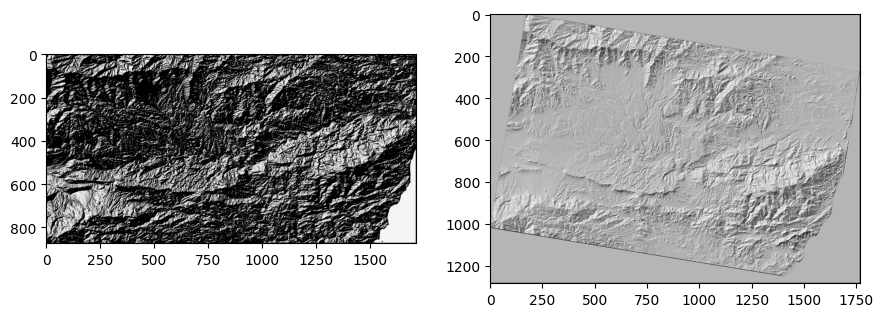

In [ ]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2)

filename = "rio_aguas_COP30_HS.tif"
with rio.open(filename) as src:
    ax1.imshow(src.read(1), cmap='gray')

filename2 = "rio_aguas_COP30_LCC_HS.tif"
with rio.open(filename2) as src2:
    ax2.imshow(src2.read(1), cmap='gray')

f.set_size_inches(10.5, 8.5)

plt.show()

What is going on?

First, the dark hillshade on the right is because the X,Y coordinates are in decimal degrees and the elevation is in metres. So you get a very distorted hillshade. **For a good hillshade you really need to use a projected coordinate system**

Second, these are image plots so the X,Y coordinates are just the row and column of the raster array. They are not spatial dimensions.

The projected hillshade is tilted because it is in a conical projection that (for this projection) spreads things out the further south you go. It you plotted a site in SE Europe (in Greece, say) the raster would be tilted the other direction.

## Striping

Okay, we want a projected coordinate system because we want spatial units in metres (or some length unit rather than latitude, longitude).

But there is a problem with the projection that we can see if we zoom in:

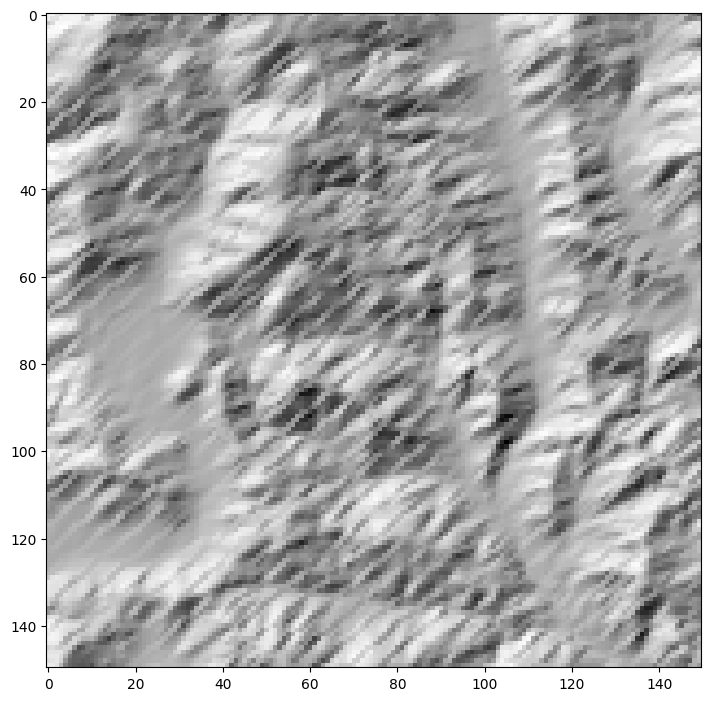

In [ ]:
%matplotlib inline
f, (ax1) = plt.subplots(1, 1)
f.set_size_inches(10.5, 8.5)

filename2 = "rio_aguas_COP30_LCC_HS.tif"
with rio.open(filename2) as src2:
    array = src2.read(1)

    # I'll zoom in with an array slice
    array2 = array[200:350, 200:350]
    ax1.imshow(array2, cmap='gray')

plt.show()

Can you see those stripes? The stripes are there because the default sampling for the projection is nearest neighbour, but every few pixels the nearest neighbour in the new projection skips a row or column in the old projects. You solve this by the changing the resampling method to either `cubic` or `bilinear`

To do this add this to the `gdalwarp` command: `-r cubic`.
While we are at it, lets make the pixel size a nice round number using `-tr 26 26` (we get 26 metre pixels that way).

In [ ]:
!gdalwarp -t_srs EPSG:3034 rio_aguas_COP30.tif rio_aguas_COP30_cubic_LCC.tif -r cubic -tr 26 26

Creating output file that is 1758P x 1278L.
Processing rio_aguas_COP30.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!gdaldem hillshade rio_aguas_COP30_cubic_LCC.tif rio_aguas_COP30_LCC_cubic_HS.tif -alg ZevenbergenThorne

0...10...20...30...40...50...60...70...80...90...100 - done.


Now we plot the hillshade. Tada! No striping!!

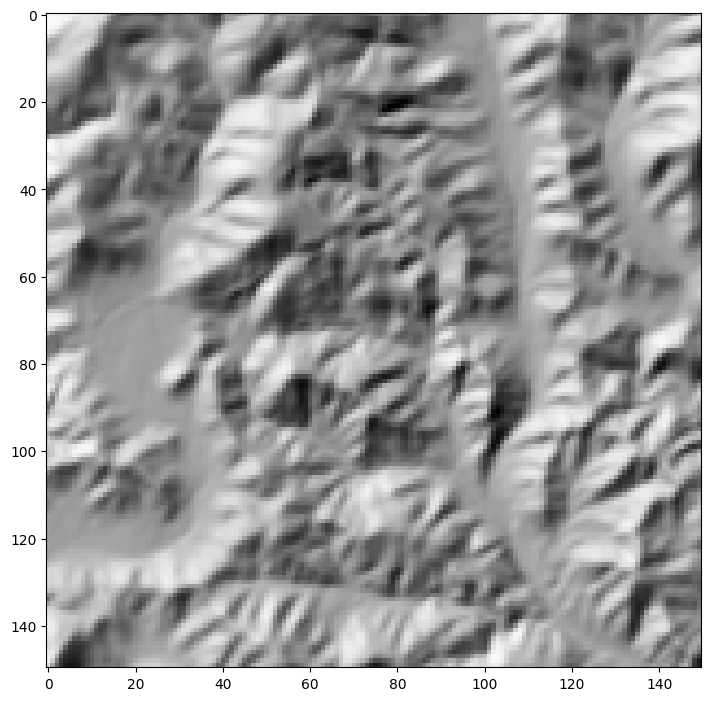

In [ ]:
%matplotlib inline
f, (ax1) = plt.subplots(1, 1)
f.set_size_inches(10.5, 8.5)

filename2 = "rio_aguas_COP30_LCC_cubic_HS.tif"
with rio.open(filename2) as src2:
    array = src2.read(1)

    # I'll zoom in with an array slice
    array2 = array[200:350, 200:350]
    ax1.imshow(array2, cmap='gray')

plt.show()

## Doing everything using rasterio (for completeness, gdal is better)

We can do all that reprojection stuff in `rasterio` if you don't want to delve into the linux command line. But it is much uglier than `gdalwarp`:

In [ ]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:3034'

with rasterio.open('rio_aguas_COP30.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('rio_aguas_COP30_LCC_cubic_rasterio.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.cubic)

In [ ]:
!gdaldem hillshade rio_aguas_COP30_LCC_cubic_rasterio.tif rio_aguas_COP30_LCC_cubic_rasterio_HS.tif -alg ZevenbergenThorne

In [ ]:
%matplotlib inline
f, (ax1) = plt.subplots(1, 1)
f.set_size_inches(10.5, 8.5)

filename2 = "rio_aguas_COP30_LCC_cubic_rasterio_HS.tif"
with rio.open(filename2) as src2:
    array = src2.read(1)

    # I'll zoom in with an array slice
    array2 = array[200:350, 200:350]
    ax1.imshow(array2, cmap='gray')

plt.show()

## What you should have learned and potential modifications

You should

* Now know what a coordinate reference system is.
* Know the difference between a projected and geographic coordinate system
* Be able to use gdal to reproject ("warp") a raster
* Know that when you warp a raster you should use either `cubic` or ` bilinear` resampling.

Further tasks

* Try projecting the DEM into the correct UTM coordinates (you will need to [look up the UTM zone](http://www.dmap.co.uk/utmworld.htm); this site is just to the east of Almeria, Spain).
* Try changing the grid cell size (to 30m pixels, for example and using either `gdalinfo` or `rasterio.meta` to check if you've done it properly.